# **AFLOW 기반 ANN&CNN 재료설계**

**1. 구글 드라이브와 연동**

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
directory = "/content/gdrive/My Drive/"

**2. 데이터 관리용 라이브러리 호출**

>파이썬, tensorflow 버젼 확인



In [ ]:
!python --version
#파이썬 버전 확인

import tensorflow as tf
print(tf.__version__)
#tensorflow 버젼 확인

Python 3.10.11
2.12.0


> Library 다운로드



In [ ]:
import requests
# API 가져오는 라이브러리

import numpy as np
# Numerical Arrary 연산 라이브러리

import pandas as pd
# 데이터 프레임 조작 및 분석 라이브러리

import json 
# API를 통해 불러온 키-값 (ex. "이름" : "홍길동")을 인간이 읽을 수 있도록 변환해 주는 라이브러리

from urllib.request import urlopen
#API의 url을 열어줄 수있는 라이브러리

from itertools import combinations
# list에서 조합섞기 (원소 조합 만들 때 사용)

**3. API를 통해 데이터 불러오기**

> url로 데이터 가져오기





In [ ]:
def aflow_database(elements, target):
    
    elements2 = ','.join(elements) #정보 합치기
    target2 = ','.join(target)
    API = "http://aflow.org/API/aflux/?"
    MATCHBOOK = f"species({elements2}),nspecies({len(elements)})," + "stoichiometry,composition," +  target2 #검색 키워드
    DIRECTIVES = "$paging(0)" #데이터를 다 가져온다
    response = pd.DataFrame(json.loads(urlopen(API + MATCHBOOK + "," + DIRECTIVES).read().decode("utf-8"))) #표로 만들어주기
    
    return response

> 데이터 전처리



In [ ]:
def get_aflow(elements):
    
    total_elements = [] # 
    for i in range(2,4): # Binary, Ternary 조합만을 사용
        total_elements += combinations(elements, i) 
        # itertools를 통해 불러온 combination 
        # 내가 선택한 element(원소)의 i개의 조합을 저장

    response = pd.DataFrame()    
    #일단 pandas를 통해 비어있는 데이터프레임을 만들고 덧붙이겠다.
    for elements in total_elements:
        response = pd.concat([response, pd.DataFrame(aflow_database(elements, target))]) 
    # Aflow API를 통해 데이터를 불러와서 데이터프레임에 concat 저장 -> append 함수는 pd에서 지원하지 않는 점 주의
    
    species = response["species"].to_list() 
    stoichiometry = response["stoichiometry"].to_list()
    composition = response["composition"].to_list()
    # species, stoichiometry, composition data는 복수형 데이터이기 때문에 list로 만들어준다.

    index_stoichio = pd.DataFrame([dict(zip(species[i], stoichiometry[i])) for i in range(len(species))]).fillna(0).reset_index(drop=True)
    index_compo = pd.DataFrame([dict(zip(species[i], composition[i])) for i in range(len(species))]).fillna(0).reset_index(drop=True)
    # species와 stoichiometry 리스트를 이용하여 딕셔너리 생성 후 데이터프레임으로 변환
    # 누락된 값을 0으로 채우고, 인덱스를 재설정하여 데이터프레임을 수정
    
    response = response.reset_index(drop=True) #데이터프레임의 인덱스를 재설정하고, 기존의 인덱스를 제거
    database_stoichio = pd.concat([index_stoichio, response], axis=1) #concat함수로 이어 붙이겠다.
    database_compo = pd.concat([index_compo, response], axis=1)  #concat함수로 이어 붙이겠다.
    
    return database_stoichio, database_compo 

> 원하는 조성, 물성값 가져오기



해당 사이트에서 원하는 물성 추출
http://materials.duke.edu/AFLOWDATA/LIB2_RAW/Ni_pvZn/73/index.php

>Binary (2가지 조성)



In [ ]:
elements = ['Cu', 'Zr']
target = ["density", "eentropy_atom", "enthalpy_atom", "enthalpy_formation_atom", "entropic_temperature", "valence_cell_std", "volume_cell"]
data,_= get_aflow(elements)

>Ternary(3가지 조성)



In [ ]:
# elements = ["Ti", "V", "Cr", "Mn", "Fe", 'Co', "Ni", "Cu"]
# target = ["density", "eentropy_atom", "enthalpy_atom", "enthalpy_formation_atom", "entropic_temperature", "valence_cell_std", "volume_cell"]
# data,_= get_aflow(elements)

>데이터 형태 확인

In [ ]:
data

,Cu,Zr,compound,auid,aurl,spacegroup_relax,Pearson_symbol_relax,species,nspecies,stoichiometry,composition,density,eentropy_atom,enthalpy_atom,enthalpy_formation_atom,entropic_temperature,valence_cell_std,volume_cell
0,0.250000,0.750000,Cu2Zr6,aflow:00faec8f444e3086,aflowlib.duke.edu:AFLOWDATA/LIB2_RAW/Cu_pvZr_s...,59,oP8,"[Cu, Zr]",2,"[0.25, 0.75]","[2, 6]",6.93770,-0.000599,-7.38523,0.046759,-964.934,46,161.4210
1,0.333333,0.666667,Cu1Zr2,aflow:01cbbc6596a48fdc,aflowlib.duke.edu:AFLOWDATA/LIB2_RAW/Cu_pvZr_sv/9,164,hP3,"[Cu, Zr]",2,"[0.333333333, 0.666666667]","[1, 2]",6.69187,-0.000154,-6.97207,0.089364,-1629.230,19,61.0397
2,0.172414,0.827586,Cu5Zr24,aflow:013ed58d2c1b4a10,aflowlib.duke.edu:AFLOWDATA/LIB2_RAW/Cu_pvZr_s...,217,cI58,"[Cu, Zr]",2,"[0.172413793, 0.827586207]","[5, 24]",6.54549,0.000459,-7.46686,0.310125,-7828.800,151,636.0090
3,0.500000,0.500000,Cu2Zr2,aflow:01c6a98b684fc205,aflowlib.duke.edu:AFLOWDATA/LIB2_RAW/Cu_pvZr_s...,51,oP4,"[Cu, Zr]",2,"[0.5, 0.5]","[2, 2]",7.38483,0.000026,-6.43947,-0.119144,1994.680,30,69.6008
4,0.500000,0.500000,Cu1Zr1,aflow:018034893881acb1,aflowlib.duke.edu:AFLOWDATA/LIB2_RAW/Cu_pvZr_s...,221,cP2,"[Cu, Zr]",2,"[0.5, 0.5]","[1, 1]",7.30236,0.000035,-6.42782,-0.107493,1799.610,15,35.1934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0.750000,0.250000,Cu3Zr1,aflow:f8a911f5e146203e,aflowlib.duke.edu:AFLOWDATA/LIB2_RAW/Cu_pvZr_s...,65,oS8,"[Cu, Zr]",2,"[0.75, 0.25]","[3, 1]",7.77017,-0.000216,-5.09492,0.113746,-2347.300,37,60.2350
243,0.666667,0.333333,Cu4Zr2,aflow:fbc993456c19effc,aflowlib.duke.edu:AFLOWDATA/LIB2_RAW/Cu_pvZr_s...,12,mS12,"[Cu, Zr]",2,"[0.666666667, 0.333333333]","[4, 2]",7.66849,0.000020,-5.61941,-0.040188,732.684,52,94.5468
244,0.166667,0.833333,Cu1Zr5,aflow:fbbdac1dc23e3efe,aflowlib.duke.edu:AFLOWDATA/LIB2_RAW/Cu_pvZr_s...,191,hP6,"[Cu, Zr]",2,"[0.166666667, 0.833333333]","[1, 5]",5.92459,0.000246,-7.05650,0.746046,-19214.900,31,145.6460
245,0.500000,0.500000,Cu2Zr2,aflow:fc27ee2ffe59bcc5,aflowlib.duke.edu:AFLOWDATA/LIB2_RAW/Cu_pvZr_s...,194,hP4,"[Cu, Zr]",2,"[0.5, 0.5]","[2, 2]",6.77857,-0.000269,-6.17576,0.144570,-2420.360,30,75.8258


>Pearson Coefficient

In [ ]:
import plotly.figure_factory as ff

In [ ]:
def Corr(data, features, type):
  
    data2 = data[features]
    matrix = data2.corr(method=type).abs() # converting range of (-1~1) to 0~1
    #matrix = data2.corr(method=type)

    fig = ff.create_annotated_heatmap(z=matrix.to_numpy().round(2),
                                      x=list(matrix.index.values),
                                      y=list(matrix.columns.values),       
                                      xgap=1, ygap=1,
                                      zmin=0, zmax=1,
                                      colorscale='blues',
                                      colorbar_thickness=30,
                                      colorbar_ticklen=3,)
  
    fig.update_layout(title_x=0.5,
                      titlefont={'size': 24},
                      width=850, height=750,
                      xaxis_showgrid=False,
                      xaxis={'side': 'bottom'},
                      yaxis_showgrid=False,
                      yaxis_autorange='reversed',                   
                      paper_bgcolor=None,)
    fig.show()

    return matrix

In [ ]:
pearson = Corr(data, target, "pearson")

>데이터 Scailing

In [ ]:
# data scaling function 
def scaler(data, scale_list, output, type):

    data = data.sort_values(by='enthalpy_formation_atom', ascending=False) #우리가 원하는 물성 값으로 내림차순으로 정렬 
    data = data.drop_duplicates(subset=elements, keep="last").reset_index(drop=True)
    # drop_duplicates() 메서드를 사용하여 중복을 제거, subset=elements 인자를 통해 중복을 확인할 열들을 지정 
    # keep="last"를 설정하여 중복된 행 중 마지막 행을 유지 
    # reset_index 사용하여 인덱스를 재설정
    data = data.dropna()
    #결측값 제거
    x = data.loc[:, scale_list] # X값으로 설정할 부분 설정
    y = data.loc[:,output] # Y값으로 설정할 부분 설정
    stats = x.describe().transpose()
    if type == 'MinMax':
      scaled = (x - stats['min']) / (stats['max']-stats['min']) #최소값과 최대값의 범위로 나누어 스케일링된 값을 계산
    elif type == 'Standard':
      scaled = (x - stats['mean']) / stats['std'] # 평균값과 표준편차로 나누어 스케일링된 값을 계산

    return scaled, y

>X값,y값 설정 후 Scaling

In [ ]:
scale_list = ["density", "eentropy_atom", "enthalpy_atom", "entropic_temperature", "valence_cell_std", "volume_cell"]
output = ["enthalpy_formation_atom"]
X_train, y_train = scaler(data, scale_list, output, 'Standard')

>데이터 확인

In [ ]:
X_train.head()

,density,eentropy_atom,enthalpy_atom,entropic_temperature,valence_cell_std,volume_cell
0,-2.035503,0.443347,-1.019708,-3.680060,0.153273,1.680165
1,-0.917749,0.277784,0.234105,-0.668471,-0.155686,-0.104784
2,-1.051261,2.318542,-0.924077,-0.733028,0.394647,1.394655
3,-1.338117,-0.310424,-1.431173,-2.034247,0.848430,3.157026
4,1.305493,-0.484841,1.485632,-0.187369,-0.281201,-0.681327


In [ ]:
y_train.head()

,enthalpy_formation_atom
0,0.642453
1,0.438075
2,0.310125
3,0.264539
4,0.127072


In [ ]:
X_train.T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
density,-2.035503,-0.917749,-1.051261,-1.338117,1.305493,-0.910567,1.254401,1.669286,-0.906269,-0.632035,...,-0.237641,0.092524,0.369014,-0.306282,1.320886,0.376725,-0.210825,0.295619,0.983052,0.670835
eentropy_atom,0.443347,0.277784,2.318542,-0.310424,-0.484841,-1.746695,-0.164041,-0.088938,-1.032441,1.018553,...,-1.578320,0.522620,0.698110,-1.035292,-0.188600,1.643155,0.646872,-1.083270,-0.165154,1.307386
enthalpy_atom,-1.019708,0.234105,-0.924077,-1.431173,1.485632,-1.277476,1.639124,1.730340,-1.365439,-1.047844,...,-0.207389,0.196481,0.432521,-0.481379,1.030546,0.299823,-0.352999,0.166134,0.815711,0.484269
entropic_temperature,-3.680060,-0.668471,-0.733028,-2.034247,-0.187369,-0.026633,-0.120794,-0.213839,0.153992,0.240454,...,0.416436,0.419106,0.472086,0.481291,0.664762,0.592199,0.670517,0.674370,0.745682,0.786865
valence_cell_std,0.153273,-0.155686,0.394647,0.848430,-0.281201,-0.686709,1.775306,3.686989,-0.648089,-0.802569,...,0.172582,-0.377750,-0.416370,-0.039827,-0.599815,-0.271546,-0.590160,-0.522575,-0.348786,-0.812224
volume_cell,1.680165,-0.104784,1.394655,3.157026,-0.681327,-0.418123,0.360714,1.194887,-0.328736,-0.699363,...,0.196145,-0.501497,-0.596167,0.087477,-0.833724,-0.462469,-0.599851,-0.648113,-0.646523,-0.924735


**4. ANN, CNN을 위한 라이브러리 호출**

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Input, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# **5.ANN**

**5-1. ANN 모델 설계 (With Bayesian Optimization)**

>ANN 모델

In [ ]:
# define ANN model structure 
def ANN(num_dense_layers, num_dense_nodes):

    model = Sequential()
    model.add(InputLayer(input_shape=(len(X_train.T),))) # 행의 갯수를 넣어 줘야하니 Transpose 시켜준다.
    for i in range(num_dense_layers): # 노드의 갯수

        model.add(Dense(num_dense_nodes,
                        activation='relu',
                        name='layer_dense_{0}'.format(i+1)))
        # num_dense_layers 개수만큼 노드를 가진 Dense 레이어를 모델에 추가하는 반복문
        model.add(BatchNormalization(name='batch_norm_{0}'.format(i+1)))
        #Batch Normalization 레이어를 모델에 추가
        #학습 과정에서 각 배치 단위 별로 데이터가 다양한 분포를 가지더라도 각 배치별로 평균과 분산을 이용해 정규화

    model.add(Dense(1, activation='linear'))

    return model

>모델 시각화

In [ ]:
# ANN: Formation enthalpy prediction model
ann = ANN(num_dense_layers=1, num_dense_nodes=1024)
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_dense_1 (Dense)       (None, 1024)              7168      
                                                                 
 batch_norm_1 (BatchNormaliz  (None, 1024)             4096      
 ation)                                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 12,289
Trainable params: 10,241
Non-trainable params: 2,048
_________________________________________________________________


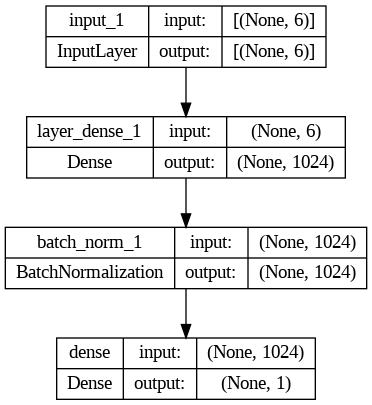

In [ ]:
plot_model(ann, to_file='model.png', show_shapes=True)

>ANN 모델 구조

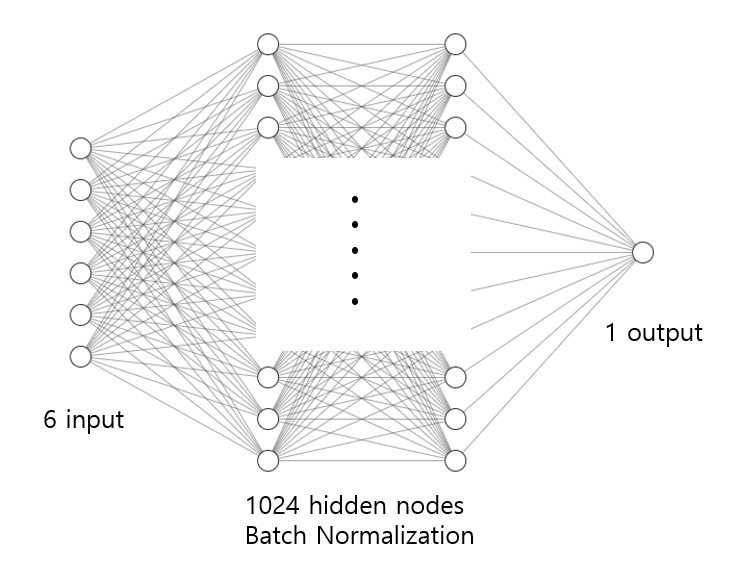

**5-2. ANN Training**

> Hyperparameter 설정, Train

In [ ]:
ann.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mae', 'mse']) 
# 옵티마이저로 Adam을 선택하고, 학습률(learning rate)을 0.005로 설정
# loss function은 MSE, MAE 사용

history_ann = ann.fit(x=X_train, y=y_train, epochs=1000, validation_split=0.1, batch_size=32) 
# epochs=1000: 전체 데이터셋에 대해 학습 반복 횟수를 1000번으로 설정
# validation_split=0.1: 훈련 데이터의 10%를 검증 데이터로 사용
# batch_size=32: 각 학습 반복에서 사용할 미니 배치의 크기를 32로 설정. 한 번의 반복에서 32개의 샘플이 모델에 입력되고 가중치 업데이트

Epoch 1/1000
1/1 [==============================] - 6s 6s/step - loss: 0.3327 - mae: 0.4806 - mse: 0.3327 - val_loss: 0.0804 - val_mae: 0.2217 - val_mse: 0.0804
Epoch 2/1000
1/1 [==============================] - 0s 72ms/step - loss: 18.6932 - mae: 3.6408 - mse: 18.6932 - val_loss: 0.1338 - val_mae: 0.3546 - val_mse: 0.1338
Epoch 3/1000
1/1 [==============================] - 0s 65ms/step - loss: 3.0391 - mae: 1.4280 - mse: 3.0391 - val_loss: 0.1190 - val_mae: 0.3414 - val_mse: 0.1190
Epoch 4/1000
1/1 [==============================] - 0s 66ms/step - loss: 4.4198 - mae: 1.6875 - mse: 4.4198 - val_loss: 0.0929 - val_mae: 0.2762 - val_mse: 0.0929
Epoch 5/1000
1/1 [==============================] - 0s 141ms/step - loss: 6.2903 - mae: 2.1667 - mse: 6.2903 - val_loss: 0.0716 - val_mae: 0.2287 - val_mse: 0.0716
Epoch 6/1000
1/1 [==============================] - 0s 90ms/step - loss: 5.2940 - mae: 2.0494 - mse: 5.2940 - val_loss: 0.0568 - val_mae: 0.2161 - val_mse: 0.0568
Epoch 7/1000
1/1 [===

> Model History Plot

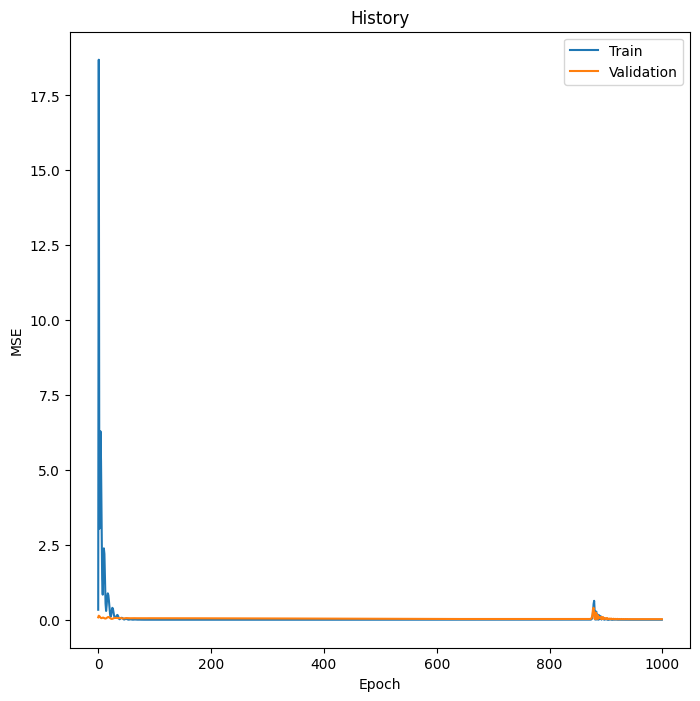

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history_ann.history['mse'])
plt.plot(history_ann.history['val_mse'])
plt.title('History')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

>R Square

1/1 [==============================] - 0s 177ms/step


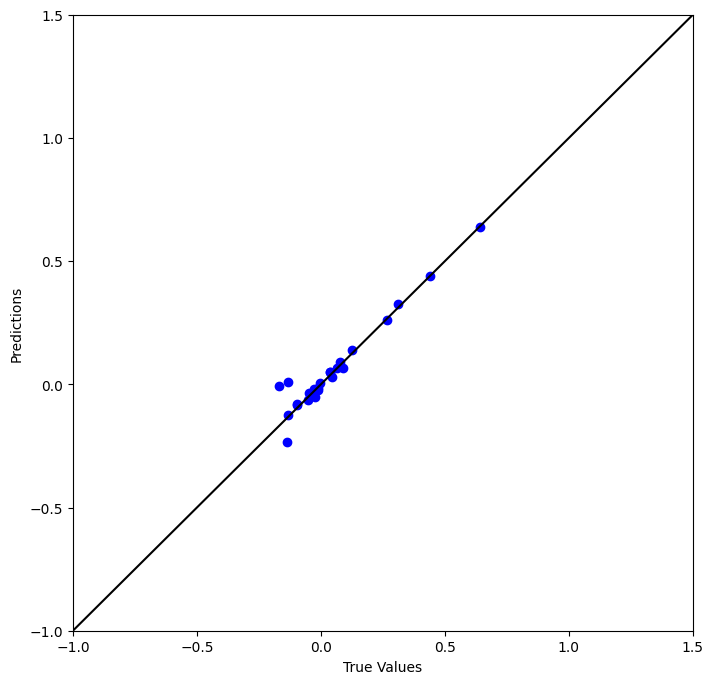

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_train, ann.predict(X_train), color='blue')
plt.plot(np.arange(-5, 5), np.arange(-5, 5), 'black')
plt.xlim(-1,1.5)
plt.ylim(-1,1.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
from sklearn.metrics import r2_score
error_r2 = r2_score(y_train, ann.predict(X_train))
print("R2: {:5.2f}".format(error_r2))

1/1 [==============================] - 0s 30ms/step
R2:  0.93


**5-3 Explainable AI For ANN**

In [ ]:
# !pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 40.1 MB/s eta 0:00:00


In [ ]:
# import shap

In [ ]:
# explainer = shap.KernelExplainer(ann.predict, X_train)
# shap_values = explainer.shap_values(X_train)

1/1 [==============================] - 0s 252ms/step


  0%|          | 0/24 [00:00<?, ?it/s]

47/47 [==============================] - 0s 2ms/step


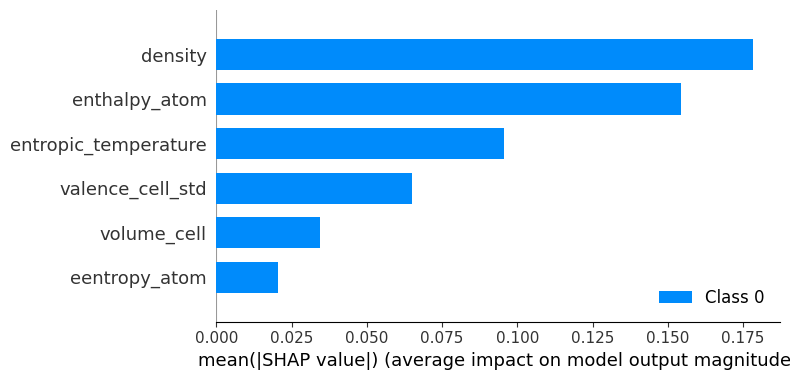

In [ ]:
# # Plot SHAP summary plot
# shap.summary_plot(shap_values, X_train, feature_names=list(X_train.columns))

**5-4 ANN with Bayesian Optimization**

In [ ]:
# # define ANN model structure 
# def ANN(learning_rate, num_dense_layers, num_dense_nodes):

#     model = Sequential()
#     model.add(InputLayer(input_shape=(len(X_train.T),))) # 행의 갯수를 넣어 줘야하니 Transpose 시켜준다.
#     for i in range(num_dense_layers): # 노드의 갯수

#         model.add(Dense(num_dense_nodes,
#                         activation='relu',
#                         name='layer_dense_{0}'.format(i+1)))
#         # num_dense_layers 개수만큼 노드를 가진 Dense 레이어를 모델에 추가하는 반복문
#         model.add(BatchNormalization(name='batch_norm_{0}'.format(i+1)))
#         #Batch Normalization 레이어를 모델에 추가
#         #학습 과정에서 각 배치 단위 별로 데이터가 다양한 분포를 가지더라도 각 배치별로 평균과 분산을 이용해 정규화

#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae', 'mse'])

#     return model

In [ ]:
# !pip install scikit-optimize

In [ ]:
# import skopt
# from tensorflow.keras.optimizers import Adam
# from sklearn.model_selection import ParameterGrid
# from skopt import gp_minimize
# from skopt.space import Real, Categorical, Integer
# from skopt.plots import plot_convergence, plot_objective
# from skopt.utils import use_named_args

In [ ]:
# dim_learning_rate = Real(low=1e-3, high=1e0, prior='log-uniform', name='learning_rate') # 러닝레이트 범위 지정.
# dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers') # hidden layer 개수 1~5까지 바꿔가며 확인.
# dim_num_dense_nodes = Integer(low=16, high=1024, name='num_dense_nodes') # 각 층의 노드 개수.
# space = [dim_learning_rate, dim_num_dense_layers, dim_num_dense_nodes]
# default_space = [1e-1, 1, 64] #initial values of hyperparameters
# default_error = 10

# # define function minimzing mean squared error - loss func. 
# @use_named_args(space)
# def objective(learning_rate, num_dense_layers, num_dense_nodes):
#     print('learning rate: {0:.1e}'.format(learning_rate))
#     print('num_dense_layers:', num_dense_layers)
#     print('num_dense_nodes:', num_dense_nodes)
    
#     model = ANN(learning_rate=learning_rate, num_dense_layers=num_dense_layers, num_dense_nodes=num_dense_nodes)
#     callbacks = [keras.callbacks.EarlyStopping(monitor='val_mse', mode='min', verbose=1, patience=30)]
#     history = model.fit(x=X_train, y=y_train, epochs=100, validation_split=0.1, batch_size=32, callbacks=callbacks)
#     history_array.append(pd.DataFrame(history.history))
#     error = history.history['val_mse'][-1]
#     print("error: {:5.2f} u_B".format(error))
    
#     global default_error
#     if error < default_error:
#        default_error = error
#        model.save(directory+'/ANN_model_gp.h5')
#     del model
#     return error

In [ ]:
# history_array=[] 
# optimization = gp_minimize(func=objective, dimensions=space, acq_func='EI', n_calls=11, x0=default_space) #Bayesian optimization using Gaussian Processes

In [ ]:
# # Convergence plot
# plt.figure(figsize=(6, 4))
# plot_convergence(optimization)

In [ ]:
# # recommended hyperparamter
# best_param = optimization.x # 베이지안 최적화 결과 최적의 하이퍼파라미터 가져옴.

# # organize optimization history
# error_history = pd.DataFrame(optimization.func_vals, columns=['val_mse'])
# structure_history = pd.DataFrame(optimization.x_iters, columns= ['lr', 'layer', 'node'])
# gp_history = pd.concat([error_history, structure_history], axis=1)

In [ ]:
# best_param

In [ ]:
# _ = plot_objective(optimization) 

## **6. CNN**

**6-1. CNN 모델 설계**

In [ ]:
# CNN 모델 구조 정의
def CNN(kernel_size, filter_size, num_dense_layers, num_dense_nodes):
    
    model = Sequential()
    model.add(InputLayer(input_shape=(len(X_train.T), 1)))  # 입력 레이어 설정 (입력 형태: (데이터 특성 수, 1))
    model.add(Conv1D(kernel_size=kernel_size,
                     strides=1, filters=filter_size,
                     padding='same', activation='relu',
                     name='layer_conv'))  # 1D 합성곱 레이어 추가 (커널 크기, 필터 수, 패딩, 활성화 함수 설정)
    model.add(Flatten())  # 2D 특성맵을 1D로 펼치는 레이어 추가
    model.add(BatchNormalization(name='batch_norm_conv'))  # 배치 정규화 레이어 추가 (1D 합성곱 레이어 이후)

    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes,
                        activation='relu',
                        name='layer_dense_{0}'.format(i+1)))  # 완전 연결 (Dense) 레이어 추가 (노드 수, 활성화 함수 설정)
        model.add(BatchNormalization(name='batch_norm_dense_{0}'.format(i+1)))  # 배치 정규화 레이어 추가 (완전 연결 레이어 이후)

    model.add(Dense(1, activation='linear'))  # 출력 레이어 추가 (출력 노드 수, 활성화 함수 설정)

    return model

**6-2. CNN Training**

>Hyperparameter, 모델 구조

In [ ]:
cnn = CNN(kernel_size=3, filter_size=10, num_dense_layers=1, num_dense_nodes=512)
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_conv (Conv1D)         (None, 6, 10)             40        
                                                                 
 flatten (Flatten)           (None, 60)                0         
                                                                 
 batch_norm_conv (BatchNorma  (None, 60)               240       
 lization)                                                       
                                                                 
 layer_dense_1 (Dense)       (None, 512)               31232     
                                                                 
 batch_norm_dense_1 (BatchNo  (None, 512)              2048      
 rmalization)                                                    
                                                                 
 dense_1 (Dense)             (None, 1)                

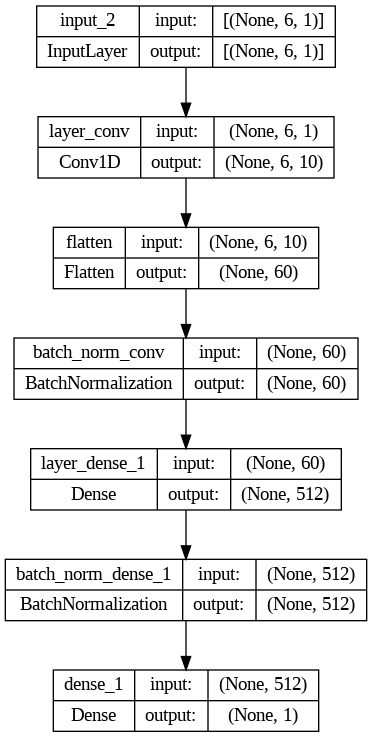

In [ ]:
plot_model(cnn, to_file='model.png', show_shapes=True)

>Training

In [ ]:
cnn.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mae', 'mse'])
history_cnn = cnn.fit(x=np.expand_dims(X_train, axis=2), y=y_train, epochs=1000, validation_split=0.1, batch_size=32)

Epoch 1/1000
1/1 [==============================] - 7s 7s/step - loss: 1.4299 - mae: 1.0112 - mse: 1.4299 - val_loss: 0.3375 - val_mae: 0.5601 - val_mse: 0.3375
Epoch 2/1000
1/1 [==============================] - 0s 41ms/step - loss: 22.6248 - mae: 4.0976 - mse: 22.6248 - val_loss: 0.1003 - val_mae: 0.3135 - val_mse: 0.1003
Epoch 3/1000
1/1 [==============================] - 0s 37ms/step - loss: 4.4803 - mae: 1.7402 - mse: 4.4803 - val_loss: 0.0082 - val_mae: 0.0747 - val_mse: 0.0082
Epoch 4/1000
1/1 [==============================] - 0s 38ms/step - loss: 5.0346 - mae: 2.0209 - mse: 5.0346 - val_loss: 0.0064 - val_mae: 0.0750 - val_mse: 0.0064
Epoch 5/1000
1/1 [==============================] - 0s 56ms/step - loss: 4.5132 - mae: 1.8471 - mse: 4.5132 - val_loss: 0.0045 - val_mae: 0.0605 - val_mse: 0.0045
Epoch 6/1000
1/1 [==============================] - 0s 41ms/step - loss: 3.0406 - mae: 1.4142 - mse: 3.0406 - val_loss: 0.0014 - val_mae: 0.0314 - val_mse: 0.0014
Epoch 7/1000
1/1 [====

> Plot

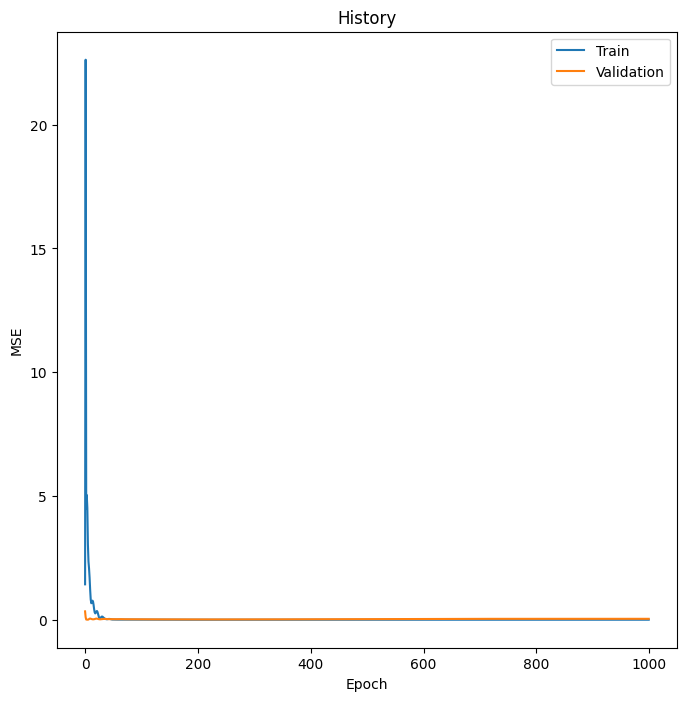

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history_cnn.history['mse'])
plt.plot(history_cnn.history['val_mse'])
plt.title('History')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 149ms/step


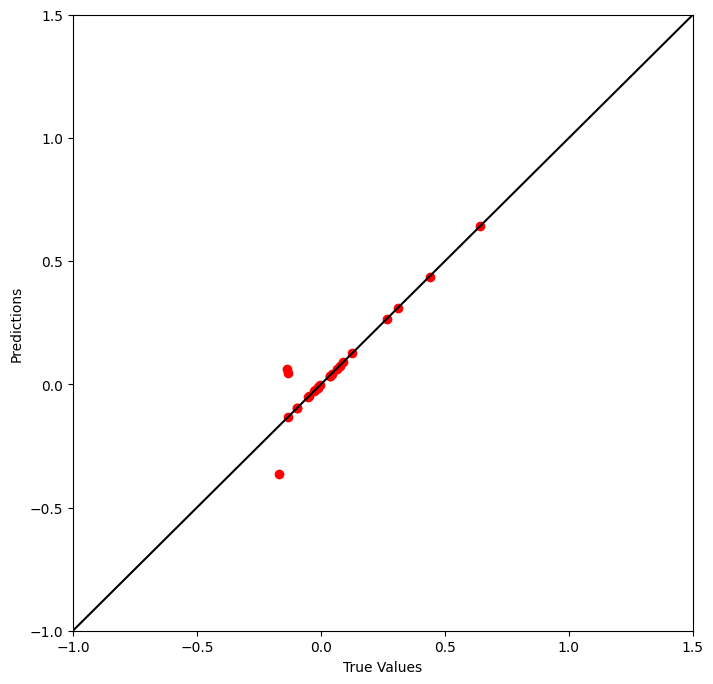

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_train, cnn.predict(X_train), color='red')
plt.plot(np.arange(-5, 5), np.arange(-5, 5), 'black')
plt.xlim(-1,1.5)
plt.ylim(-1,1.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
from sklearn.metrics import r2_score
error_r2 = r2_score(y_train, cnn.predict(X_train))
print("R2: {:5.2f}".format(error_r2))

1/1 [==============================] - 0s 27ms/step
R2:  0.87
